# Understanding Zero Mean and Unit Variance in MLP Layers
## We'll track activations at each layer (pre and post activation)

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Create a custom MLP that stores intermediate activations
class MLPWithActivationTracking(nn.Module):
    def __init__(self, layers):
        """
        MLP that tracks pre-activation and post-activation values at each layer.
        """
        super(MLPWithActivationTracking, self).__init__()
        
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            # ReLU for all but the last layer
            if i < len(layers) - 2:
                self.activations.append(nn.ReLU())
            else:
                self.activations.append(nn.Identity())  # No activation on last layer
        
        # Storage for tracking
        self.pre_activations = []
        self.post_activations = []
    
    def forward(self, x):
        self.pre_activations = []
        self.post_activations = []
        
        for linear, activation in zip(self.layers, self.activations):
            x = linear(x)
            self.pre_activations.append(x.detach().clone())
            
            x = activation(x)
            self.post_activations.append(x.detach().clone())
        
        return x


torch.manual_seed(2026)
# define the input layers through this seq schema
layer_dims = [786, 256, 512, 256, 128, 8]
# Create the MLP  
mlp = MLPWithActivationTracking(layers=layer_dims)

# Generate random input samples (1000 samples, 786 features)
num_samples = 1000
X = torch.randn(num_samples, 786)  # Standard normal input (mean=0, std=1)

print(f"Input Statistics:")
print(f"  Mean: {X.mean().item():.4f}")
print(f"  Std:  {X.std().item():.4f}")
print(f"  Shape: {X.shape}")

# Forward pass to collect activations
with torch.no_grad():
    output = mlp(X)

print(f"\nNetwork Architecture: {layer_dims}")
print(f"Number of layers: {len(mlp.layers)}")

Input Statistics:
  Mean: -0.0008
  Std:  0.9998
  Shape: torch.Size([1000, 786])

Network Architecture: [786, 256, 512, 256, 128, 8]
Number of layers: 5


# Collect statistics for each layer

In [ ]:

layer_stats = []

for i, (pre, post) in enumerate(zip(mlp.pre_activations, mlp.post_activations)):
    stats = {
        'layer': i + 1,
        'dim': layer_dims[i + 1],
        'pre_mean': pre.mean().item(),
        'pre_std': pre.std().item(),
        'pre_var': pre.var().item(),
        'pre_min': pre.min().item(),
        'pre_max': pre.max().item(),
        'post_mean': post.mean().item(),
        'post_std': post.std().item(),
        'post_var': post.var().item(),
        'post_min': post.min().item(),
        'post_max': post.max().item(),
    }
    layer_stats.append(stats)
    
    print(f"\n{'='*60}")
    print(f"Layer {i+1}: {layer_dims[i]} → {layer_dims[i+1]}")
    print(f"{'='*60}")
    print(f"PRE-ACTIVATION (after Linear, before ReLU):")
    print(f"  Mean:     {stats['pre_mean']:>8.4f}  (Target: 0)")
    print(f"  Std:      {stats['pre_std']:>8.4f}  (Target: 1, because √variance = √1 = 1)")
    print(f"  Variance: {stats['pre_var']:>8.4f}  (Target: 1)")
    print(f"  Range:    [{stats['pre_min']:.2f}, {stats['pre_max']:.2f}]")
    print(f"\nPOST-ACTIVATION (after ReLU):")
    print(f"  Mean:     {stats['post_mean']:>8.4f}")
    print(f"  Std:      {stats['post_std']:>8.4f}")
    print(f"  Variance: {stats['post_var']:>8.4f}")
    print(f"  Range:    [{stats['post_min']:.2f}, {stats['post_max']:.2f}]")


Layer 1: 786 → 256
PRE-ACTIVATION (after Linear, before ReLU):
  Mean:      -0.0016  (Target: 0)
  Std:        0.5777  (Target: 1, because √variance = √1 = 1)
  Variance:   0.3337  (Target: 1)
  Range:    [-2.72, 3.02]

POST-ACTIVATION (after ReLU):
  Mean:       0.2295
  Std:        0.3366
  Variance:   0.1133
  Range:    [0.00, 3.02]

Layer 2: 256 → 512
PRE-ACTIVATION (after Linear, before ReLU):
  Mean:       0.0101  (Target: 0)
  Std:        0.2356  (Target: 1, because √variance = √1 = 1)
  Variance:   0.0555  (Target: 1)
  Range:    [-1.10, 1.14]

POST-ACTIVATION (after ReLU):
  Mean:       0.0990
  Std:        0.1406
  Variance:   0.0198
  Range:    [0.00, 1.14]

Layer 3: 512 → 256
PRE-ACTIVATION (after Linear, before ReLU):
  Mean:       0.0088  (Target: 0)
  Std:        0.1010  (Target: 1, because √variance = √1 = 1)
  Variance:   0.0102  (Target: 1)
  Range:    [-0.43, 0.42]

POST-ACTIVATION (after ReLU):
  Mean:       0.0449
  Std:        0.0611
  Variance:   0.0037
  Range:

# Now let's add Layer Normalization and see how it prevents variance collapse!

COMPARISON: Without vs With Layer Normalization

Layer 1: 786 → 256

WITHOUT LayerNorm:                       WITH LayerNorm:                         
--------------------------------------------------------------------------------
PRE-ACTIVATION (after Linear):          
  Mean:  -0.0016  Var: 0.3337    Mean:  -0.0030  Var: 0.3343

AFTER LayerNorm:                        
  N/A                                         Mean:  -0.0000  Var: 1.0000  YES!!!

POST-ACTIVATION (after ReLU):           
  Mean:   0.2295  Var: 0.1133    Mean:   0.3990  Var: 0.3408

Layer 2: 256 → 512

WITHOUT LayerNorm:                       WITH LayerNorm:                         
--------------------------------------------------------------------------------
PRE-ACTIVATION (after Linear):          
  Mean:   0.0101  Var: 0.0555    Mean:  -0.0134  Var: 0.1674

AFTER LayerNorm:                        
  N/A                                         Mean:  -0.0000  Var: 0.9999  YES!!!

POST-ACTIVATION (after ReLU)

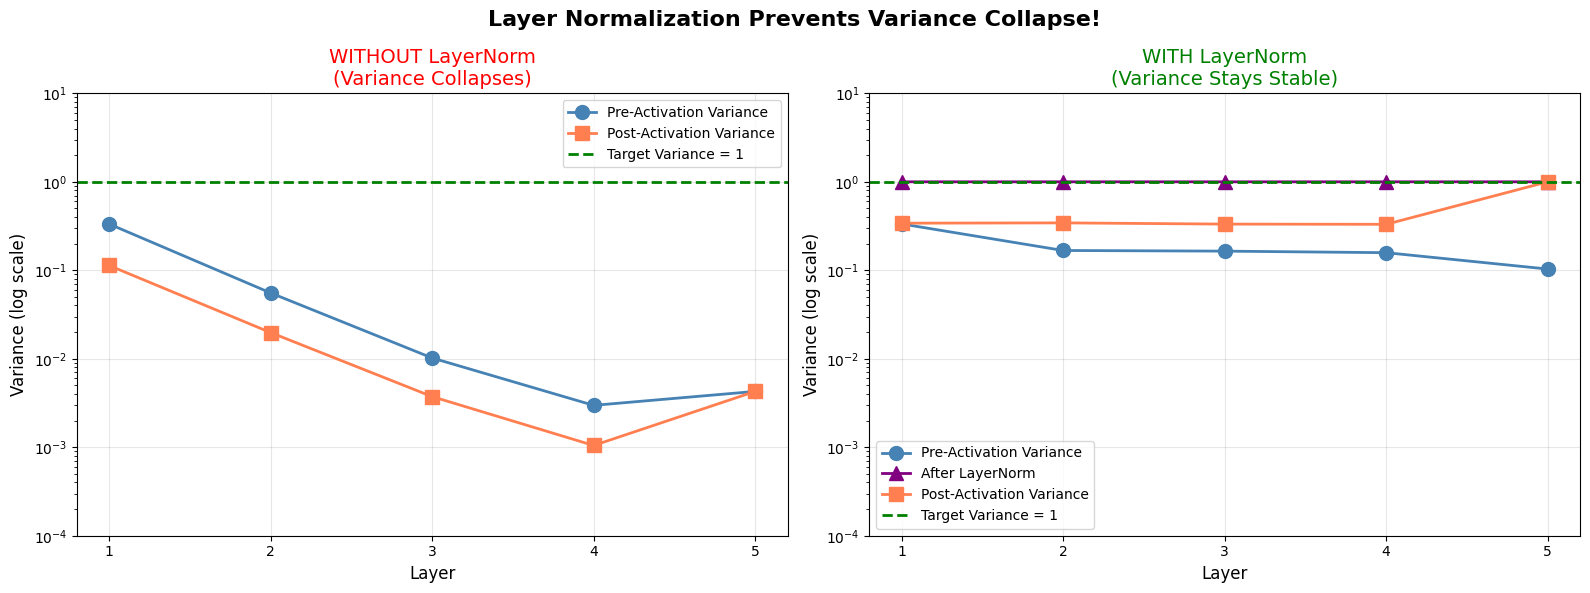

In [ ]:
class MLPWithLayerNorm(nn.Module):
    def __init__(self, layers):
        """
        MLP with Layer Normalization after each linear layer (before activation).
        """
        super(MLPWithLayerNorm, self).__init__()
        
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        self.activations = nn.ModuleList()
        
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            # Add LayerNorm after each linear layer
            self.layer_norms.append(nn.LayerNorm(layers[i + 1]))
            
            # ReLU for all but the last layer
            if i < len(layers) - 2:
                self.activations.append(nn.ReLU())
            else:
                self.activations.append(nn.Identity())
        
        # Storage for tracking
        self.pre_activations = []
        self.post_norm = []
        self.post_activations = []
    
    def forward(self, x):
        self.pre_activations = []
        self.post_norm = []
        self.post_activations = []
        
        for linear, layer_norm, activation in zip(self.layers, self.layer_norms, self.activations):
            x = linear(x)
            self.pre_activations.append(x.detach().clone())
            
            x = layer_norm(x)
            self.post_norm.append(x.detach().clone())
            
            x = activation(x)
            self.post_activations.append(x.detach().clone())
        
        return x

# Create the MLP with LayerNorm
torch.manual_seed(42)
mlp_ln = MLPWithLayerNorm(layers=layer_dims)

# print(mlp_ln)
# Use the same input data
with torch.no_grad():
    output_ln = mlp_ln(X)

print("=" * 80)
print("COMPARISON: Without vs With Layer Normalization")
print("=" * 80)

# Collect statistics for LayerNorm model
layer_stats_ln = []
for i, (pre, post_norm, post) in enumerate(zip(mlp_ln.pre_activations, mlp_ln.post_norm, mlp_ln.post_activations)):
    stats = {
        'layer': i + 1,
        'dim': layer_dims[i + 1],
        'pre_mean': pre.mean().item(),
        'pre_std': pre.std().item(),
        'pre_var': pre.var().item(),
        'post_norm_mean': post_norm.mean().item(),
        'post_norm_std': post_norm.std().item(),
        'post_norm_var': post_norm.var().item(),
        'post_mean': post.mean().item(),
        'post_std': post.std().item(),
        'post_var': post.var().item(),
    }
    layer_stats_ln.append(stats)

# Side-by-side comparison
for i in range(len(layer_stats)):
    print(f"\n{'='*80}")
    print(f"Layer {i+1}: {layer_dims[i]} → {layer_dims[i+1]}")
    print(f"{'='*80}")
    
    print(f"\n{'WITHOUT LayerNorm:':<40} {'WITH LayerNorm:':<40}")
    print("-" * 80)
    
    # Pre-activation (after Linear, before normalization)
    print(f"{'PRE-ACTIVATION (after Linear):':<40}")
    print(f"  Mean: {layer_stats[i]['pre_mean']:>8.4f}  Var: {layer_stats[i]['pre_var']:>6.4f}    "
          f"Mean: {layer_stats_ln[i]['pre_mean']:>8.4f}  Var: {layer_stats_ln[i]['pre_var']:>6.4f}")
    
    # After normalization (only for LayerNorm model)
    print(f"\n{'AFTER LayerNorm:':<40}")
    print(f"  {'N/A':<40}    Mean: {layer_stats_ln[i]['post_norm_mean']:>8.4f}  Var: {layer_stats_ln[i]['post_norm_var']:>6.4f}  YES!!!")
    
    # Post-activation (after ReLU)
    print(f"\n{'POST-ACTIVATION (after ReLU):':<40}")
    print(f"  Mean: {layer_stats[i]['post_mean']:>8.4f}  Var: {layer_stats[i]['post_var']:>6.4f}    "
          f"Mean: {layer_stats_ln[i]['post_mean']:>8.4f}  Var: {layer_stats_ln[i]['post_var']:>6.4f}")

# Visualize the variance trajectory comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Layer Normalization Prevents Variance Collapse!', fontsize=16, fontweight='bold')

layers = [s['layer'] for s in layer_stats]

# Left: Without LayerNorm
pre_vars = [s['pre_var'] for s in layer_stats]
post_vars = [s['post_var'] for s in layer_stats]

axes[0].semilogy(layers, pre_vars, 'o-', linewidth=2, markersize=10, color='steelblue', label='Pre-Activation Variance')
axes[0].semilogy(layers, post_vars, 's-', linewidth=2, markersize=10, color='coral', label='Post-Activation Variance')
axes[0].axhline(y=1, color='green', linestyle='--', linewidth=2, label='Target Variance = 1')
axes[0].set_xlabel('Layer', fontsize=12)
axes[0].set_ylabel('Variance (log scale)', fontsize=12)
axes[0].set_title('WITHOUT LayerNorm\n(Variance Collapses)', fontsize=14, color='red')
axes[0].set_xticks(layers)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0.0001, 10)

# Right: With LayerNorm
pre_vars_ln = [s['pre_var'] for s in layer_stats_ln]
post_norm_vars_ln = [s['post_norm_var'] for s in layer_stats_ln]
post_vars_ln = [s['post_var'] for s in layer_stats_ln]

axes[1].semilogy(layers, pre_vars_ln, 'o-', linewidth=2, markersize=10, color='steelblue', label='Pre-Activation Variance')
axes[1].semilogy(layers, post_norm_vars_ln, '^-', linewidth=2, markersize=10, color='purple', label='After LayerNorm')
axes[1].semilogy(layers, post_vars_ln, 's-', linewidth=2, markersize=10, color='coral', label='Post-Activation Variance')
axes[1].axhline(y=1, color='green', linestyle='--', linewidth=2, label='Target Variance = 1')
axes[1].set_xlabel('Layer', fontsize=12)
axes[1].set_ylabel('Variance (log scale)', fontsize=12)
axes[1].set_title('WITH LayerNorm\n(Variance Stays Stable)', fontsize=14, color='green')
axes[1].set_xticks(layers)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0.0001, 10)

plt.tight_layout()
plt.show()